In [1]:
import glob
import csv
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import collections
import requests
import os
import io
import zipfile
import datetime
import time 

from datetime import datetime


In [4]:
def property_price_sq_meter(row):
    if row['Area_Type'] == 'M':
        return  row['Purchase_Price'] / row['Area']


cols = """Record_Type
District Code
Property Id
Sale Counter
Download Date Time
Property Name
Property Unit Number
Property House Number
Property Street Name
Property Locality
Property Post Code
Area
Area Type
Contract Date
Settlement Date
Purchase Price
Zoning
Nature of Property
Primary Purpose
Strata Lot Number
Component code
Sale Code
Percentage Interest of Sale
Dealing Number
Empty"""
col_header = [((i.replace(" ","_").replace("\n", ",")).split(",")) for i in cols.split('/n')]

lst_pds = [pd.read_csv(f, 
                       sep=';', 
                       error_bad_lines=False, 
                       quoting=csv.QUOTE_NONE, 
                       header=None ,  
                       encoding='utf-8',
                       index_col=None
                      ) for f in glob.glob('../data/sales/B_str/201*.csv')]

df_sale = pd.concat(lst_pds)
df_sale.columns = col_header[0]
# Add Downloaded_Date from 
df_sale['Download_Date'] = pd.to_datetime(df_sale['Download_Date_Time'].str[:8]) 

#Deduplicate 
df_sale_dedup = df_sale.drop_duplicates(subset=[i for i in df_sale.columns if i != 'Download_Date'], keep=False)
df_sale_dedup['Property_Price_Sq_Meter'] = df_sale_dedup.apply(property_price_sq_meter, axis=1)

print(len(df_sale_dedup))
df_sale_dedup.head(1)

1042566


,Record_Type,District_Code,Property_Id,Sale_Counter,Download_Date_Time,Property_Name,Property_Unit_Number,Property_House_Number,Property_Street_Name,Property_Locality,...,Nature_of_Property,Primary_Purpose,Strata_Lot_Number,Component_code,Sale_Code,Percentage_Interest_of_Sale,Dealing_Number,Empty,Download_Date,Property_Price_Sq_Meter
0,B,157,2994800.0,1,2018012201:15,NaN,NaN,7,DENNISCRES,SOUTHWESTROCKS,...,R,RESIDENCE,NaN,MSW,NaN,0.0,AN44948,NaN,2018-01-22,617.527263


In [11]:
#df_sale_dedup.columns
#df_sale_dedup.dtypes

### filter with years 

In [5]:
suburb_lst = ['QUAKERSHILL', 'KINGSLANGLEY', 'KINGSPARK']
#df_sale_dedup[df_sale_dedup.Download_Date.dt.strftime('%Y').between('2012','2012')]
#(df_sale_dedup.Download_Date.dt.strftime('%Y').between('2016','2018')) & 

df_time_ser_price = df_sale_dedup[(df_sale.Download_Date > '2016-01-01') & 
                                  (df_sale.Download_Date < '2018-12-01') &
                                  #(df_sale.Property_Locality.isin(suburb_lst)) &
                                  (df_sale.Nature_of_Property == 'R')
                                 ]\
                                     [['Download_Date','Property_Locality', "Property_Price_Sq_Meter"]]\
                                        .groupby(['Property_Locality','Download_Date'])\
                                        .agg(['mean','count'])

df_time_ser_price =  df_time_ser_price.reset_index()
df_time_ser_price.columns = ["Property_Locality","date_sold","Property_Price_Sq_Meter","sold_counts"]


In [9]:
df_time_ser_price.index = df_time_ser_price.date_sold
df_time_ser_price.head()

,Property_Locality,date_sold,Property_Price_Sq_Meter,sold_counts
date_sold,,,,
2016-04-04,AARONSPASS,2016-04-04,NaN,0
2016-01-25,ABBOTSBURY,2016-01-25,1259.400467,2
2016-02-08,ABBOTSBURY,2016-02-08,1279.090268,1
2016-02-15,ABBOTSBURY,2016-02-15,1560.000000,1
2016-02-22,ABBOTSBURY,2016-02-22,1172.739342,1


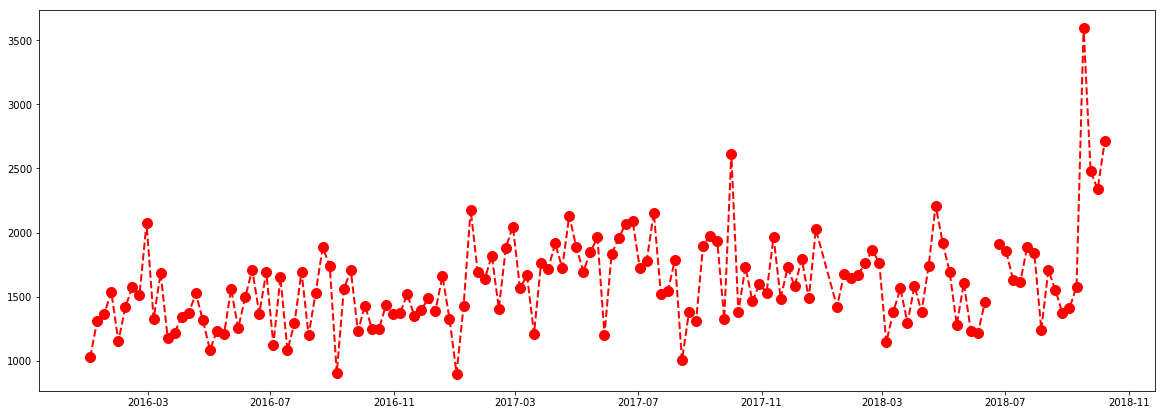

In [21]:
plt.figure(figsize=(20,7))

plt.plot_date(x = df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]["date_sold"], 
         y= df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]['Property_Price_Sq_Meter'], 
         color='red', 
         marker='o', 
         linestyle='dashed', 
         linewidth=2, 
         markersize=10,
         label = df_time_ser_price['Property_Locality']
        )


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

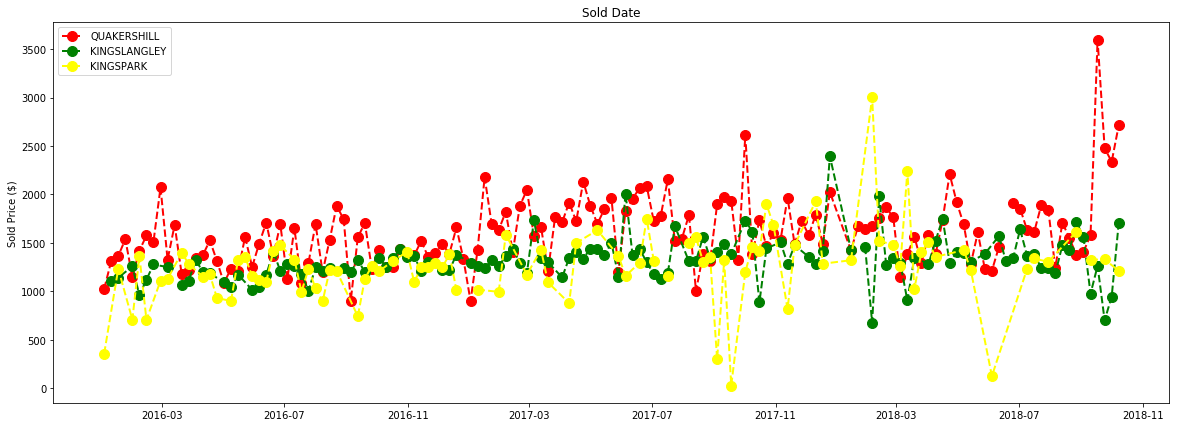

In [20]:
plt.figure(figsize=(20,7))
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]['Property_Price_Sq_Meter'], 
         color='red', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'QUAKERSHILL')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]['Property_Price_Sq_Meter'], 
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'KINGSLANGLEY')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]['Purchase_Price'], 
#         color='Blue', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'MARAYONG')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]['Property_Price_Sq_Meter'], 
         color='Yellow', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'KINGSPARK')





plt.ylabel('Sold Price ($)') 
plt.title('Sold Date')
plt.legend();
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

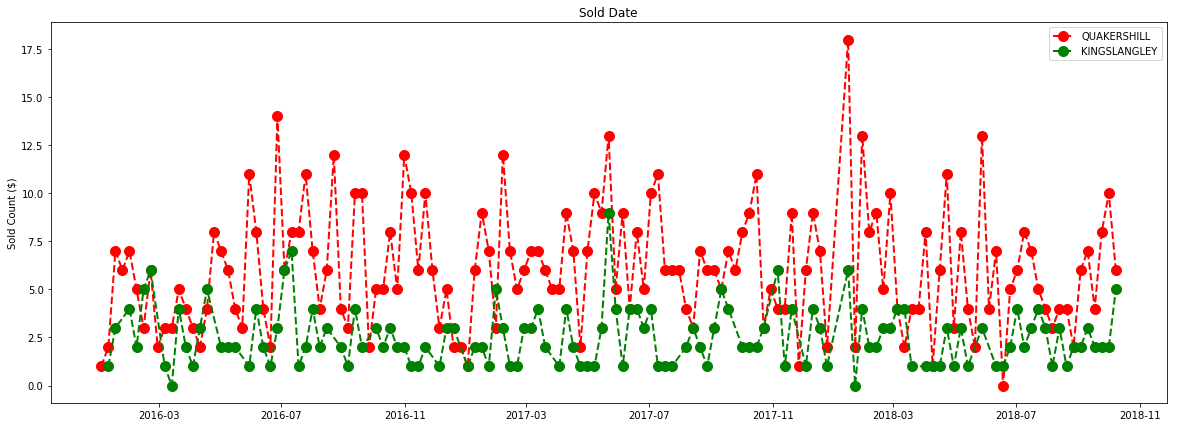

In [32]:
plt.figure(figsize=(20,7))
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]['sold_counts'], 
         color='red', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'QUAKERSHILL')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]['sold_counts'], 
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'KINGSLANGLEY')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]['sold_counts'], 
#         color='Blue', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'MARAYONG')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]['sold_counts'], 
#         color='Yellow', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'KINGSPARK')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]['sold_counts'], 
#         color='Black', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'GLENWOOD')



plt.ylabel('Sold Count ($)') 
plt.title('Sold Date')
plt.legend();
plt